### Segmentanything 2.1-Different methods to generate masks using Point-based, box-based and automatic mask generation methods
##### Analyzed by: Harpreet Kaur Bargota (email : harpreet.bargota@agr.gc.ca)

References include:
https://github.com/facebookresearch/sam2 and https://ai.meta.com/research/publications/sam-2-segment-anything-in-images-and-videos/

Adapted from https://github.com/facebookresearch/sam2/blob/main/sam2/automatic_mask_generator.py

In [10]:
#Import the required libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import pandas as pd
import seaborn as sns
import os as os
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [11]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='yellow', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure()
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=10)
        plt.axis('off')
        plt.show()


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)        

For experimentation, image Vf1-1-2 has been used. 

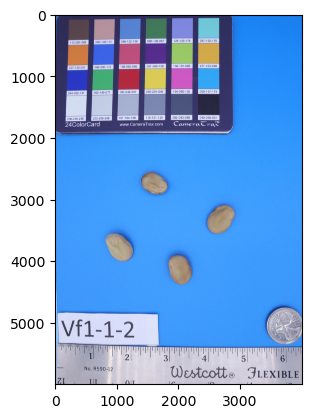

In [12]:
image=cv2.imread("../data/Faba-Seed-CC_Vf1-1-2.JPG")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.axis('on')
plt.show()


#### Predictor based SAM 2.1:

This code imports two key components from the sam2 library:

build_sam2: This function is responsible for initializing and building the SAM2 (Segment Anything Model v2) model.

SAM2ImagePredictor: This class is responsible for processing images and generating segmentation masks.

model_cfg: This variable stores the path to a YAML configuration file (sam2.1_hiera_l.yaml), which defines various hyperparameters and settings for the model.

sam2_checkpoint: This variable stores the path to a pre-trained checkpoint file (sam2.1_hiera_large.pt). This checkpoint contains the learned weights of the model, which allow it to make predictions without requiring retraining.

device: Runs the model on the CPU

build_sam2 function: loads the model architecture, configures the model parameters based on sam2.1_hiera_l.yaml, loads the pre-trained weights from sam2.1_hiera_large.pt

SAM2ImagePredictor instance: for processing images and generating segmentation masks.The predictor is initialized with the sam2_model created earlier.

set_image(image) function: preprocesses the image (resizing, normalizing, converting to tensors, etc.), prepares it for segmentation, stores it in memory so the model can generate masks based on it.


In [13]:
#import the required libraries
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

#specify the model configs and checkpoints
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
# checkpoint = "/checkpoints/sam2.1_hiera_large.pt"

# specify the device used
device = "cpu"

# use sam predictor for generating masks
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device) #initialises the SAM2.1 model
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

#### Point based SAM2.1

Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point).The single input point is ambiguous, and the model has returned multiple objects consistent with it.

In [14]:
# input x,y points and label number for detecting that particular seed
input_point = np.array([[1600, 2700]]) 
input_label = np.array([1])


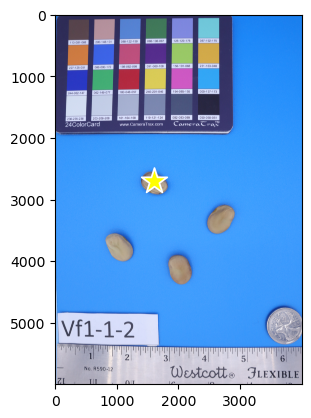

In [15]:
# visualize the point on the image for a particular seed
plt.figure()
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [16]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [17]:
# generate the masks
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [19]:
masks.shape 

(3, 6000, 4000)

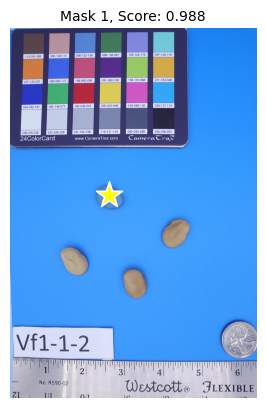

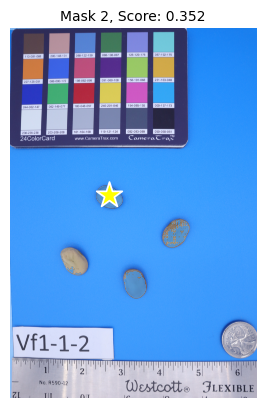

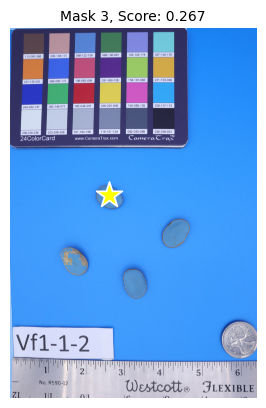

In [20]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

#### Box-based SAM2.1
Box based prompt: 
The model can also take a box as input, provided in xyxy format (diagonally opposite x1y1 and x2y2). 


In [21]:
# rectangular box coordinates for a seed[x1,y2,x2,y1]
input_box = np.array([1300,3000,1900,2400])
# input_box = np.array([2300,3700,3000,3000])
# input_box = np.array([1700,4500,2300,3800])
# input_box = np.array([700,4200,1400,3400])

In [22]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

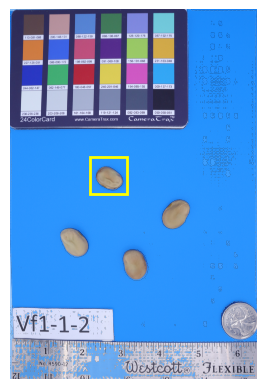

In [23]:
show_masks(image, masks, scores, box_coords=input_box)

#### Batched Input points
SamPredictor can take multiple input prompts for the same image, using predictor.predict method. This method assumes input points are already torch tensors and have already been transformed to the input frame. 

In [24]:
input_boxes = np.array([
    [1300,3000,1900,2400],
    [2300,3700,3000,3000],
    [1700,4500,2300,3800],
    [700,4200,1400,3400],
])


In [25]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [26]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

(4, 1, 6000, 4000)

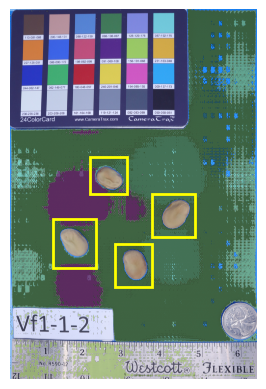

In [27]:
plt.figure()
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

### Automatic mask generation

In [28]:
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# model_cfg = "../configs/sam2.1/sam2.1_hiera_l.yaml"
model_cfg ="configs/sam2.1/sam2.1_hiera_l.yaml"
checkpoint = "checkpoints/sam2.1_hiera_large.pt"
device = "cpu"

sam_model = build_sam2(model_cfg, checkpoint)
sam_model.to(device)
mask_generator = SAM2AutomaticMaskGenerator(sam_model)

In [29]:
masks = mask_generator.generate(image)

In [30]:
print(len(masks))
print(masks[0].keys())

72
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


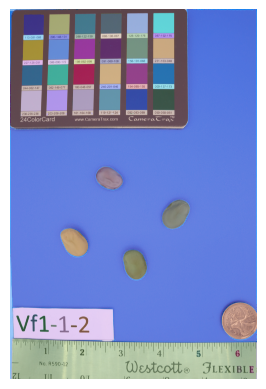

In [31]:
plt.figure()
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

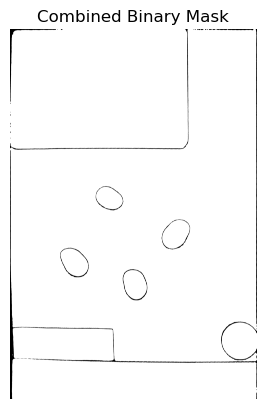

In [32]:

height, width, _ = image.shape
combined_mask = np.zeros((height, width), dtype=np.uint8)

for mask in masks:
    combined_mask = np.logical_or(combined_mask, mask['segmentation'])

plt.figure()
plt.imshow(combined_mask, cmap='gray')
plt.axis('off')
plt.title('Combined Binary Mask')
plt.show()
